# **Installation de pytorch geometric et l'initialisation des données**

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 38.8 MB/s 
     |████████████████████████████████| 3.5 MB 32.0 MB/s 


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric

In [3]:
!pip install ogb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 7.3 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=7948944d8570572f13fd64c007757ad77c4ce4a36ab338b55193d878789ae912
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


In [4]:
# define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [5]:
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from torch.utils.data.dataloader import default_collate

# initialisation des données et des Dataloaders
dataset = PygGraphPropPredDataset(name = 'ogbg-molhiv') 
dataset.data.to(device)
split_idx = dataset.get_idx_split() 
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=512 ,shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=512, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=512, shuffle=False)

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 98631.53it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:01<00:00, 37251.83it/s]


Saving...


Done!
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# Initialisation de atom encoder et bond encoder qui nous crée des embeddings des données. Atom correspond aux noeuds 
# bond correspond aux arêtes
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
atom_encoder = AtomEncoder(emb_dim = 20)
bond_encoder = BondEncoder(emb_dim = 20)
atom_encoder = atom_encoder.to(device)
bond_encoder = bond_encoder.to(device)

# **Développement des Modeles GNN**


#1.   GCN
#2.   GAT
#3.   GSAGE 
#4.   GAT+SAGE

In [7]:
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.nn import global_mean_pool
from torch.nn import Linear
import torch.nn.functional as F

In [8]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, emb_size ,hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(emb_size, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch,edge_attr):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv3(x,edge_index)
        x = pyg_nn.global_mean_pool(x, batch)
        x = self.lin(x)
        x = F.log_softmax(x,dim=1)
        return x

modelGCN = GCN(emb_size=20,hidden_channels=64)
modelGCN = modelGCN.to(device)

In [9]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self,emb_size ,hidden_channels):
        super().__init__()
        self.conv1 = GATConv(emb_size, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index,batch,edge_attr):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin2(x)
        x = F.log_softmax(x,dim=1)
        return x

modelGAT = GAT(emb_size=20,hidden_channels=30)
modelGAT = modelGAT.to(device)
modelGAT

GAT(
  (conv1): GATConv(20, 30, heads=1)
  (conv2): GATConv(30, 30, heads=1)
  (lin1): Linear(in_features=30, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=2, bias=True)
)

In [16]:
# le développement des reseaux de neurones pour la classification des graphes
# est pareil pour la classification des noeuds sauf qu'ici on ajoute une couche 
# global_mean_pool
from torch_geometric.nn import SAGEConv
class GSAGE(torch.nn.Module):
    def __init__(self,emb_size ,hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(emb_size, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index,batch,edge_attr):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv3(x,edge_index)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin2(x)
        x = F.log_softmax(x,dim=1)
        return x

modelSAGE = GSAGE(emb_size=20,hidden_channels=30)
modelSAGE = modelSAGE.to(device)
modelSAGE

GSAGE(
  (conv1): SAGEConv(20, 30, aggr=mean)
  (conv2): SAGEConv(30, 30, aggr=mean)
  (conv3): SAGEConv(30, 30, aggr=mean)
  (lin1): Linear(in_features=30, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=2, bias=True)
)

In [11]:
# le développement des reseaux de neurones pour la classification des graphes
# est pareil pour la classification des noeuds sauf qu'ici on ajoute une couche 
# global_mean_pool
from torch_geometric.nn import SAGEConv,GATConv
class GATSAGE(torch.nn.Module):
    def __init__(self,emb_size ,hidden_channels):
        super().__init__()
        self.conv1 = GATConv(emb_size, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index,batch,edge_attr):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv3(x,edge_index)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin2(x)
        x = F.log_softmax(x,dim=1)
        return x

modelGATSAGE = GATSAGE(emb_size=20,hidden_channels=30)
modelGATSAGE = modelGATSAGE.to(device)
modelGATSAGE

GATSAGE(
  (conv1): GATConv(20, 30, heads=1)
  (conv2): SAGEConv(30, 30, aggr=mean)
  (conv3): SAGEConv(30, 30, aggr=mean)
  (lin1): Linear(in_features=30, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=2, bias=True)
)

# **Entraînement et Test des Modèles**

#1.   GCN
#2.   GAT
#3.   GSAGE
#4.   GAT+SAGE

In [12]:
evaluator = Evaluator(name='ogbg-molhiv')
criterion = torch.nn.CrossEntropyLoss()
atom_encoderGCN = AtomEncoder(emb_dim = 20)
bond_encoderGCN = BondEncoder(emb_dim = 20)
atom_encoderGCN = atom_encoderGCN.to(device)
bond_encoderGCN = bond_encoderGCN.to(device)
optimizerGCN = torch.optim.Adam(list(modelGCN.parameters())+list(atom_encoderGCN.parameters())+list(bond_encoderGCN.parameters()), 
                          lr=0.01)
def train():
    modelGCN.train()
    running_loss = 0.0
    for data in train_loader:
         data.x = atom_encoderGCN(data.x)
         data.edge_attr = bond_encoderGCN(data.edge_attr)
         out = modelGCN(data.x, data.edge_index, data.batch,data.edge_attr)
         loss = F.cross_entropy(out, data.y.squeeze(1))
         loss.backward()
         optimizerGCN.step()
         running_loss += loss.item()
         optimizerGCN.zero_grad()
    return float(running_loss/len(train_loader))

def test(loader):
     modelGCN.eval()
     y_true = []
     y_pred = []
     correct = 0
     for data in loader:
         data.x = atom_encoderGCN(data.x)
         data.edge_attr = bond_encoderGCN(data.edge_attr)
         out = modelGCN(data.x, data.edge_index, data.batch,data.edge_attr)  
         # pour eva;luer le model on crée une liste de toutes les prédiction
         # pour tous les batches et une liste de toutes les étiquettes
         # et puis on utilisel'evaluator de ogb pour calculer le roc-auc
         # qui nous donne la précision du model
         y_pred_batch = out[:, 1]
         y_true.append(data.y.view(y_pred_batch.shape).detach().cpu())     
         y_pred.append(y_pred_batch.detach().cpu())
     y_true = torch.cat(y_true, dim = 0).numpy()
     y_pred = torch.cat(y_pred, dim = 0).numpy()
     acc = evaluator.eval({'y_true': y_true.reshape(len(y_true),1),
                                'y_pred': y_pred.reshape(len(y_true),1),
                               })
     return acc['rocauc']

losses_GCN = []
train_acc_GCN = []
test_acc_GCN = []
for epoch in range(1, 51):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    losses_GCN.append(loss)
    train_acc_GCN.append(train_acc)
    test_acc_GCN.append(test_acc)
    print(f'Epoch: {epoch:03d},Loss : {loss:.4f} ,Train: {train_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001,Loss : 0.1724 ,Train: 0.6463, Test: 0.6432
Epoch: 002,Loss : 0.1580 ,Train: 0.6848, Test: 0.6734
Epoch: 003,Loss : 0.1552 ,Train: 0.6928, Test: 0.6354
Epoch: 004,Loss : 0.1524 ,Train: 0.7195, Test: 0.6671
Epoch: 005,Loss : 0.1526 ,Train: 0.7124, Test: 0.6588
Epoch: 006,Loss : 0.1499 ,Train: 0.7320, Test: 0.6742
Epoch: 007,Loss : 0.1503 ,Train: 0.7322, Test: 0.6630
Epoch: 008,Loss : 0.1468 ,Train: 0.7359, Test: 0.6685
Epoch: 009,Loss : 0.1492 ,Train: 0.7463, Test: 0.6858
Epoch: 010,Loss : 0.1461 ,Train: 0.7273, Test: 0.6786
Epoch: 011,Loss : 0.1454 ,Train: 0.7520, Test: 0.6784
Epoch: 012,Loss : 0.1434 ,Train: 0.7526, Test: 0.6948
Epoch: 013,Loss : 0.1420 ,Train: 0.7571, Test: 0.6846
Epoch: 014,Loss : 0.1411 ,Train: 0.7588, Test: 0.6749
Epoch: 015,Loss : 0.1397 ,Train: 0.7599, Test: 0.7128
Epoch: 016,Loss : 0.1388 ,Train: 0.7524, Test: 0.6848
Epoch: 017,Loss : 0.1411 ,Train: 0.7605, Test: 0.6872
Epoch: 018,Loss : 0.1398 ,Train: 0.7735, Test: 0.6779
Epoch: 019,Loss : 0.1396 ,Tr

In [13]:
evaluator = Evaluator(name='ogbg-molhiv')
criterion = torch.nn.CrossEntropyLoss()
atom_encoderGAT = AtomEncoder(emb_dim = 20)
bond_encoderGAT = BondEncoder(emb_dim = 20)
atom_encoderGAT = atom_encoderGAT.to(device)
bond_encoderGAT = bond_encoderGAT.to(device)
optimizerGAT = torch.optim.Adam(list(modelGAT.parameters())+list(atom_encoderGAT.parameters())+list(bond_encoderGAT.parameters()), 
                          lr=0.01)
def train():
    modelGAT.train()
    running_loss = 0.0
    for data in train_loader:
         data.x = atom_encoderGAT(data.x)
         data.edge_attr = bond_encoderGAT(data.edge_attr)
         out = modelGAT(data.x, data.edge_index, data.batch,data.edge_attr)
         loss = F.cross_entropy(out, data.y.squeeze(1))
         loss.backward()
         optimizerGAT.step()
         running_loss += loss.item()
         optimizerGAT.zero_grad()
    return float(running_loss/len(train_loader))

def test(loader):
     modelGAT.eval()
     y_true = []
     y_pred = []
     correct = 0
     for data in loader:
         data.x = atom_encoderGAT(data.x)
         data.edge_attr = bond_encoderGAT(data.edge_attr)
         out = modelGAT(data.x, data.edge_index, data.batch,data.edge_attr)  
         # pour eva;luer le model on crée une liste de toutes les prédiction
         # pour tous les batches et une liste de toutes les étiquettes
         # et puis on utilisel'evaluator de ogb pour calculer le roc-auc
         # qui nous donne la précision du model
         y_pred_batch = out[:, 1]
         y_true.append(data.y.view(y_pred_batch.shape).detach().cpu())     
         y_pred.append(y_pred_batch.detach().cpu())
     y_true = torch.cat(y_true, dim = 0).numpy()
     y_pred = torch.cat(y_pred, dim = 0).numpy()
     acc = evaluator.eval({'y_true': y_true.reshape(len(y_true),1),
                                'y_pred': y_pred.reshape(len(y_true),1),
                               })
     return acc['rocauc']

losses_GAT = []
train_acc_GAT = []
test_acc_GAT = []
for epoch in range(1, 51):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    losses_GAT.append(loss)
    train_acc_GAT.append(train_acc)
    test_acc_GAT.append(test_acc)
    print(f'Epoch: {epoch:03d},Loss : {loss:.4f} ,Train: {train_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001,Loss : 0.1902 ,Train: 0.6279, Test: 0.5878
Epoch: 002,Loss : 0.1605 ,Train: 0.6706, Test: 0.6111
Epoch: 003,Loss : 0.1582 ,Train: 0.7054, Test: 0.6544
Epoch: 004,Loss : 0.1527 ,Train: 0.7161, Test: 0.6674
Epoch: 005,Loss : 0.1522 ,Train: 0.7263, Test: 0.6612
Epoch: 006,Loss : 0.1512 ,Train: 0.7289, Test: 0.6591
Epoch: 007,Loss : 0.1507 ,Train: 0.7188, Test: 0.6281
Epoch: 008,Loss : 0.1503 ,Train: 0.7277, Test: 0.6543
Epoch: 009,Loss : 0.1487 ,Train: 0.7329, Test: 0.6644
Epoch: 010,Loss : 0.1491 ,Train: 0.7276, Test: 0.6546
Epoch: 011,Loss : 0.1496 ,Train: 0.7173, Test: 0.6691
Epoch: 012,Loss : 0.1477 ,Train: 0.7295, Test: 0.6676
Epoch: 013,Loss : 0.1481 ,Train: 0.7312, Test: 0.6680
Epoch: 014,Loss : 0.1484 ,Train: 0.7324, Test: 0.6652
Epoch: 015,Loss : 0.1486 ,Train: 0.7294, Test: 0.6788
Epoch: 016,Loss : 0.1479 ,Train: 0.7309, Test: 0.6709
Epoch: 017,Loss : 0.1482 ,Train: 0.7300, Test: 0.6776
Epoch: 018,Loss : 0.1463 ,Train: 0.7424, Test: 0.6870
Epoch: 019,Loss : 0.1470 ,Tr

In [17]:
evaluator = Evaluator(name='ogbg-molhiv')
criterion = torch.nn.CrossEntropyLoss()
atom_encoderSAGE = AtomEncoder(emb_dim = 20)
bond_encoderSAGE = BondEncoder(emb_dim = 20)
atom_encoderSAGE = atom_encoderSAGE.to(device)
bond_encoderSAGE = bond_encoderSAGE.to(device)
optimizerSAGE = torch.optim.Adam(list(modelSAGE.parameters())+list(atom_encoderSAGE.parameters())+list(bond_encoderSAGE.parameters()), 
                          lr=0.01)
evaluator = Evaluator(name='ogbg-molhiv')
criterion = torch.nn.CrossEntropyLoss()
def train():
    modelSAGE.train()
    running_loss = 0.0
    for data in train_loader:
         data.x = atom_encoderSAGE(data.x)
         data.edge_attr = bond_encoderSAGE(data.edge_attr)
         out = modelSAGE(data.x, data.edge_index, data.batch,data.edge_attr)
         loss = F.cross_entropy(out, data.y.squeeze(1))
         loss.backward()
         optimizerSAGE.step()
         running_loss += loss.item()
         optimizerSAGE.zero_grad()
    return float(running_loss/len(train_loader))

def test(loader):
     modelSAGE.eval()
     y_true = []
     y_pred = []
     correct = 0
     for data in loader:
         data.x = atom_encoderSAGE(data.x)
         data.edge_attr = bond_encoderSAGE(data.edge_attr)
         out = modelSAGE(data.x, data.edge_index, data.batch,data.edge_attr)  
         y_pred_batch = out[:,1]
         y_true.append(data.y.view(y_pred_batch.shape).detach().cpu())     
         y_pred.append(y_pred_batch.detach().cpu())
     y_true = torch.cat(y_true, dim = 0).numpy()
     y_pred = torch.cat(y_pred, dim = 0).numpy()
     acc = evaluator.eval({'y_true': y_true.reshape(len(y_true),1),
                                'y_pred': y_pred.reshape(len(y_true),1),
                               })
     return acc['rocauc']

losses_SAGE = []
train_acc_SAGE = []
test_acc_SAGE = []
for epoch in range(1, 51):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    losses_SAGE.append(loss)
    train_acc_SAGE.append(train_acc)
    test_acc_SAGE.append(test_acc)
    print(f'Epoch: {epoch:03d},Loss : {loss:.4f} ,Train: {train_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001,Loss : 0.1760 ,Train: 0.5958, Test: 0.6674
Epoch: 002,Loss : 0.1631 ,Train: 0.6797, Test: 0.6756
Epoch: 003,Loss : 0.1575 ,Train: 0.7028, Test: 0.6751
Epoch: 004,Loss : 0.1538 ,Train: 0.7166, Test: 0.7052
Epoch: 005,Loss : 0.1512 ,Train: 0.7447, Test: 0.7023
Epoch: 006,Loss : 0.1503 ,Train: 0.7425, Test: 0.6967
Epoch: 007,Loss : 0.1488 ,Train: 0.7414, Test: 0.7262
Epoch: 008,Loss : 0.1472 ,Train: 0.7566, Test: 0.7151
Epoch: 009,Loss : 0.1488 ,Train: 0.7344, Test: 0.7174
Epoch: 010,Loss : 0.1435 ,Train: 0.7575, Test: 0.7341
Epoch: 011,Loss : 0.1449 ,Train: 0.7621, Test: 0.6923
Epoch: 012,Loss : 0.1450 ,Train: 0.7550, Test: 0.7220
Epoch: 013,Loss : 0.1434 ,Train: 0.7475, Test: 0.7255
Epoch: 014,Loss : 0.1435 ,Train: 0.7481, Test: 0.6653
Epoch: 015,Loss : 0.1443 ,Train: 0.7462, Test: 0.7157
Epoch: 016,Loss : 0.1409 ,Train: 0.7451, Test: 0.7179
Epoch: 017,Loss : 0.1415 ,Train: 0.7650, Test: 0.7302
Epoch: 018,Loss : 0.1392 ,Train: 0.7591, Test: 0.7379
Epoch: 019,Loss : 0.1399 ,Tr

In [18]:
evaluator = Evaluator(name='ogbg-molhiv')
criterion = torch.nn.CrossEntropyLoss()
atom_encoderGATSAGE = AtomEncoder(emb_dim = 20)
bond_encoderGATSAGE = BondEncoder(emb_dim = 20)
atom_encoderGATSAGE = atom_encoderGATSAGE.to(device)
bond_encoderGATSAGE = bond_encoderGATSAGE.to(device)
optimizerGATSAGE = torch.optim.Adam(list(modelGATSAGE.parameters())+list(atom_encoderGATSAGE.parameters())+list(bond_encoderGATSAGE.parameters()), 
                          lr=0.01)
evaluator = Evaluator(name='ogbg-molhiv')
criterion = torch.nn.CrossEntropyLoss()
def train():
    modelGATSAGE.train()
    running_loss = 0.0
    for data in train_loader:
         data.x = atom_encoderGATSAGE(data.x)
         data.edge_attr = bond_encoderGATSAGE(data.edge_attr)
         out = modelGATSAGE(data.x, data.edge_index, data.batch,data.edge_attr)
         loss = F.cross_entropy(out, data.y.squeeze(1))
         loss.backward()
         optimizerGATSAGE.step()
         running_loss += loss.item()
         optimizerGATSAGE.zero_grad()
    return float(running_loss/len(train_loader))

def test(loader):
     modelGATSAGE.eval()
     y_true = []
     y_pred = []
     correct = 0
     for data in loader:
         data.x = atom_encoderGATSAGE(data.x)
         data.edge_attr = bond_encoderGATSAGE(data.edge_attr)
         out = modelGATSAGE(data.x, data.edge_index, data.batch,data.edge_attr)  
         y_pred_batch = out[:,1]
         y_true.append(data.y.view(y_pred_batch.shape).detach().cpu())     
         y_pred.append(y_pred_batch.detach().cpu())
     y_true = torch.cat(y_true, dim = 0).numpy()
     y_pred = torch.cat(y_pred, dim = 0).numpy()
     acc = evaluator.eval({'y_true': y_true.reshape(len(y_true),1),
                                'y_pred': y_pred.reshape(len(y_true),1),
                               })
     return acc['rocauc']

losses_GATSAGE = []
train_acc_GATSAGE = []
test_acc_GATSAGE = []
for epoch in range(1, 51):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    losses_GATSAGE.append(loss)
    train_acc_GATSAGE.append(train_acc)
    test_acc_GATSAGE.append(test_acc)
    print(f'Epoch: {epoch:03d},Loss : {loss:.4f} ,Train: {train_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001,Loss : 0.1838 ,Train: 0.6427, Test: 0.6043
Epoch: 002,Loss : 0.1588 ,Train: 0.6744, Test: 0.6743
Epoch: 003,Loss : 0.1574 ,Train: 0.7071, Test: 0.6947
Epoch: 004,Loss : 0.1550 ,Train: 0.7145, Test: 0.6950
Epoch: 005,Loss : 0.1535 ,Train: 0.7187, Test: 0.7079
Epoch: 006,Loss : 0.1512 ,Train: 0.7217, Test: 0.7031
Epoch: 007,Loss : 0.1513 ,Train: 0.7299, Test: 0.7075
Epoch: 008,Loss : 0.1486 ,Train: 0.7362, Test: 0.6646
Epoch: 009,Loss : 0.1481 ,Train: 0.7297, Test: 0.7013
Epoch: 010,Loss : 0.1490 ,Train: 0.7390, Test: 0.7063
Epoch: 011,Loss : 0.1502 ,Train: 0.7352, Test: 0.6727
Epoch: 012,Loss : 0.1469 ,Train: 0.7386, Test: 0.6833
Epoch: 013,Loss : 0.1466 ,Train: 0.7535, Test: 0.7058
Epoch: 014,Loss : 0.1456 ,Train: 0.7431, Test: 0.7214
Epoch: 015,Loss : 0.1465 ,Train: 0.7483, Test: 0.6960
Epoch: 016,Loss : 0.1461 ,Train: 0.7521, Test: 0.7131
Epoch: 017,Loss : 0.1441 ,Train: 0.7417, Test: 0.6900
Epoch: 018,Loss : 0.1469 ,Train: 0.7458, Test: 0.7108
Epoch: 019,Loss : 0.1458 ,Tr

# **Graphes de l'Evaluation des losses, Train Accuracy et Test Accuracy pour tous les Modèles**

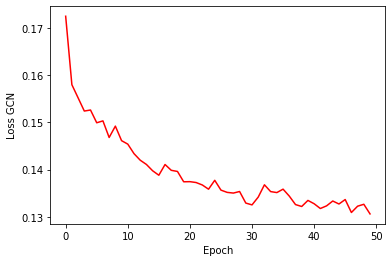

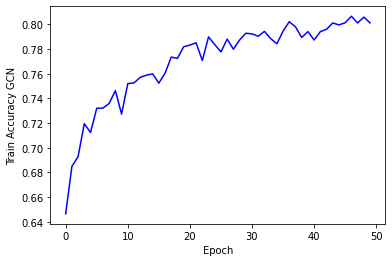

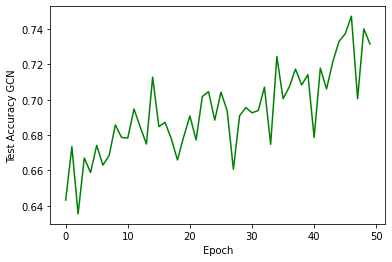

In [19]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses_GCN)), losses_GCN, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss GCN')
plt.show()

plt.plot(np.arange(len(train_acc_GCN )), train_acc_GCN , 'b')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy GCN')
plt.show()

plt.plot(np.arange(len(test_acc_GCN )), test_acc_GCN , 'g')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy GCN')
plt.show()

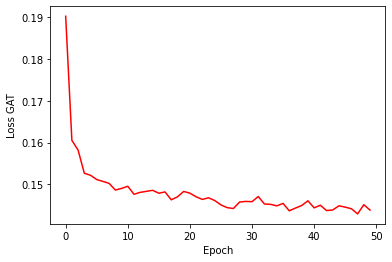

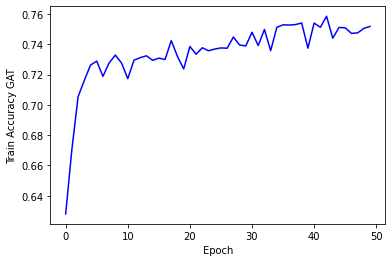

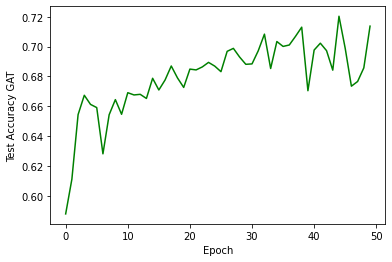

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses_GAT)), losses_GAT, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss GAT')
plt.show()

plt.plot(np.arange(len(train_acc_GAT )), train_acc_GAT , 'b')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy GAT')
plt.show()

plt.plot(np.arange(len(test_acc_GAT )), test_acc_GAT , 'g')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy GAT')
plt.show()

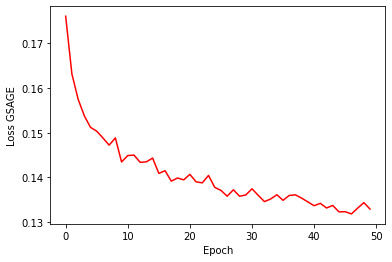

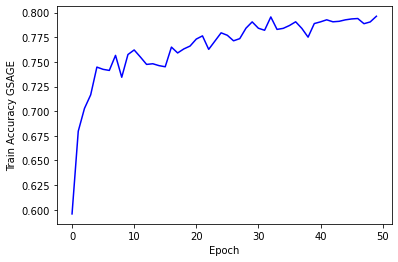

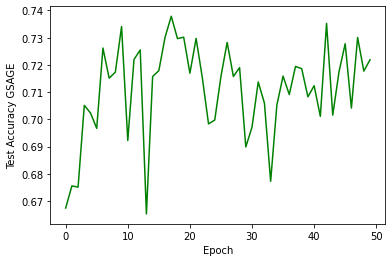

In [21]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses_SAGE)), losses_SAGE, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss GSAGE')
plt.show()

plt.plot(np.arange(len(train_acc_SAGE )), train_acc_SAGE , 'b')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy GSAGE')
plt.show()

plt.plot(np.arange(len(test_acc_SAGE )), test_acc_SAGE , 'g')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy GSAGE')
plt.show()

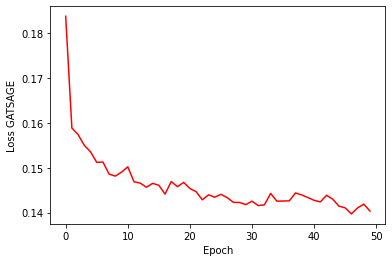

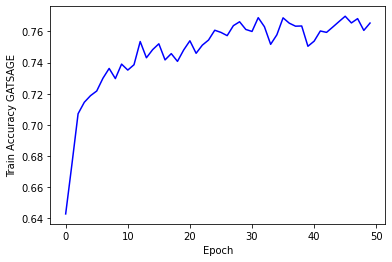

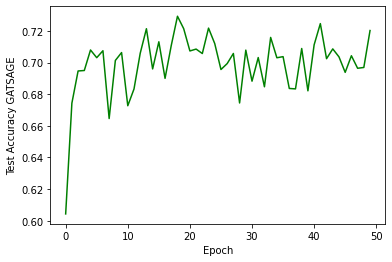

In [22]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses_GATSAGE)), losses_GATSAGE, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss GATSAGE')
plt.show()

plt.plot(np.arange(len(train_acc_GATSAGE )), train_acc_GATSAGE , 'b')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy GATSAGE')
plt.show()

plt.plot(np.arange(len(test_acc_GATSAGE )), test_acc_GATSAGE , 'g')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy GATSAGE')
plt.show()